---
# <b>1. Create harmonized/standardized PFT table<b>

In [37]:
import pandas as pd
import geopandas as gpd
import uuid
import matplotlib.pyplot as plt
import re
from math import ceil
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import numpy as np

## 1.a Concatenate fcover tables

In [25]:
sources = ['abr', 'akveg', 'ava', 'neon', 'sp']
dfs = []
for source in sources:
    path = f'{source}/output_data/{source}_standardized_fcover.csv'
    df = pd.read_csv(path, index_col=0)
    dfs.append(df)
fcover = pd.concat(dfs)

# set data types
intcols = ['surveyYear', 'surveyMonth', 'surveyDay', 'bioclimSubzone']
for col in intcols:
    fcover[col] = fcover[col].astype('Int64')
    
# rename columns for ESS-Dive
def camel_to_snake(name):
    name = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name)
    name = re.sub('([a-z0-9])([A-Z])', r'\1_\2', name)
    return name.lower()

# adjust column names and index
fcover.columns = [camel_to_snake(col) for col in fcover.columns]
fcover.index.name = 'plot_id'
fcover['unique_id'] = pd.factorize(fcover.index)[0]
fcover = fcover.reset_index()
fcover = fcover.set_index('unique_id')

# separate into two tables
non_cover_columns = [col for col in fcover.columns if not col.endswith('cover') and col not in ['unique_id', 'plot_id']]
aux = fcover[['plot_id'] + non_cover_columns]
fcover = fcover.drop(non_cover_columns, axis=1)

# export
fcover.to_csv('harmonized_pft_fcover.csv')
aux.to_csv('plot_information.csv')

In [27]:
fcover.head(3)

,plot_id,deciduous_shrub_cover,deciduous_tree_cover,evergreen_shrub_cover,evergreen_tree_cover,forb_cover,graminoid_cover,nonvascular_sum_cover,bryophyte_cover,lichen_cover,litter_cover,water_cover,bareground_cover
unique_id,,,,,,,,,,,,,
0,120712b1,32.45,0.0,20.52,0.0,2.64,19.20,33.09,31.77,1.32,18.54,0.0,0.00
1,120713a1,0.00,0.0,0.00,0.0,1.96,28.75,37.25,36.60,0.65,77.78,0.0,11.11
2,120713b1,11.34,0.0,38.01,0.0,0.00,14.66,26.00,17.34,8.66,32.67,0.0,0.00


## 1.b Fill in missing variables manually

## 1.c Load fixed table

In [28]:
aux.columns

Index(['plot_id', 'survey_year', 'survey_month', 'survey_day', 'plot_radius',
       'latitude_y', 'longitude_x', 'georef_source', 'georef_accuracy',
       'coord_epsg', 'data_subsource', 'data_source', 'survey_method',
       'fcover_scale', 'survey_purpose', 'geometry', 'admin_unit',
       'admin_country', 'fire_years', 'bioclim_subzone', 'duplicated_coords',
       'duplicated_date'],
      dtype='object')

In [30]:
aux.groupby('data_subsource').count()['plot_id']

data_subsource
AIM NPR-A Timm Nawrocki                      185
Atqasuk Vera Komarkova                        31
Barrow DOE NGEE Victoria Sloan                48
Barrow IBP Tundra Biome Pat Webber            33
Flux Tower Zona Scott Davidson               140
NGEE-Arctic Amy Breen                         98
Prudhoe ArcSEES road study Donald Walker      29
Prudhoe Bay Airport ArcSEES Donald Walker     27
Shell Onshore Matthew Macander               107
Toolik Field Station NEON                     84
Utqiagvik-Barrow NEON                        196
Name: plot_id, dtype: int64

In [22]:
# Initialize the MinMaxScaler with the desired feature range
scaler = MinMaxScaler(feature_range=(0, 100))

# Fit and transform the data
cover_cols = [col for col in fcover.columns if 'cover' in col]
fcover_scaled = pd.DataFrame(scaler.fit_transform(fcover[cover_cols]), columns=cover_cols)

## 1.d Plot PFT distribution

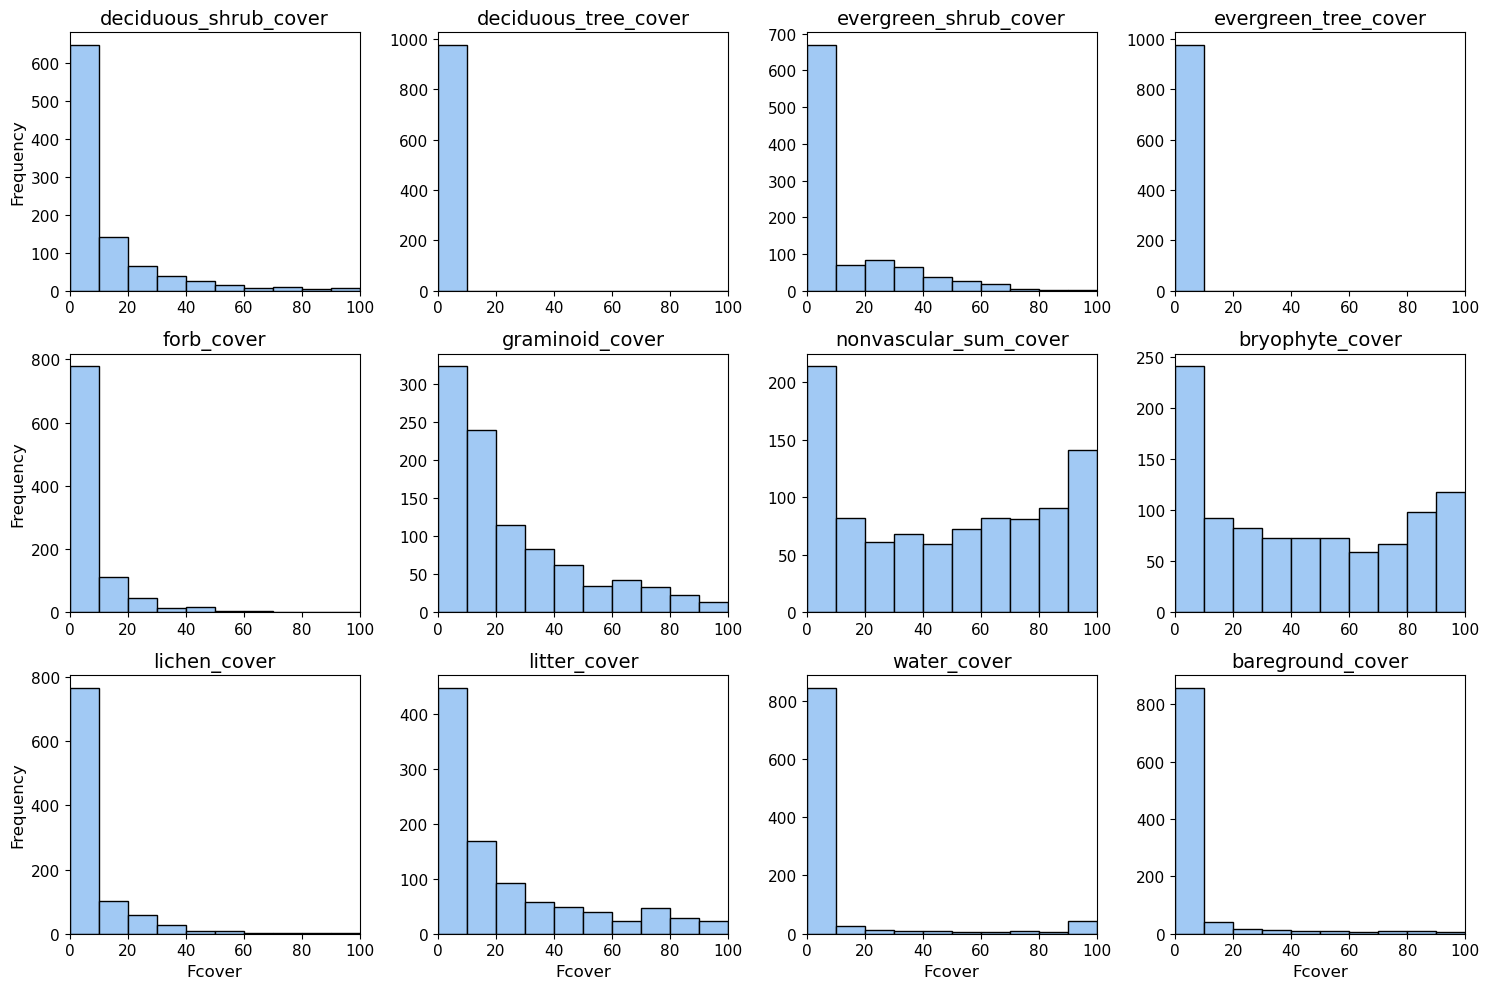

In [31]:
# List of fcover types (assuming columns represent different fcover types)
fcover_types = [col for col in fcover_scaled.columns if 'cover' in col]

# Number of subplots (assuming 10 fcover types)
num_subplots = len(fcover_types)
nrows = 3
ncols = ceil(num_subplots / nrows)

# Determine the common x and y axis ranges
all_values = pd.concat([fcover_scaled[col].dropna() for col in fcover_types])
x_min, x_max = all_values.min(), all_values.max()

# Create a figure and subplots
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 10), sharex=True)

# Flatten the array of axes for easy iteration
axs = axs.flatten()

# Set Seaborn style and color palette
palette = sns.color_palette("pastel")

# Define bin edges
bin_width = 10  # Adjust as needed
# num_bins = int((x_max - x_min) / bin_width)

# Define bin edges
bin_edges = range(int(x_min), int(x_max) + bin_width, bin_width)

# Plot each fcover type in a separate subplot
for i, fcover_type in enumerate(fcover_types):
    axs[i].hist(fcover[fcover_type], bins=bin_edges, color=palette[0], edgecolor='black', align='mid')
    axs[i].set_title(fcover_type, fontsize=14)
    axs[i].set_xlim(x_min, x_max)
    axs[i].tick_params(axis='both', which='major', labelsize=11)
    axs[i].xaxis.set_tick_params(labelbottom=True)
    
    # Set x-axis label only for the bottom row
    if i >= (nrows - 1) * ncols:
        axs[i].set_xlabel('Fcover', fontsize=12)
    
    # Set y-axis label only for the far-left column
    if i % ncols == 0:
        axs[i].set_ylabel('Frequency', fontsize=12)
    
# # Set y-axis limits based on the highest bin count across all subplots
# max_y = max(ax.get_ylim()[1] for ax in axs[:num_subplots])
# for ax in axs[:num_subplots]:
#     ax.set_ylim(0, max_y)

# Remove any empty subplots
for j in range(num_subplots, len(axs)):
    fig.delaxes(axs[j])

# Adjust layout
plt.tight_layout()
plt.show()

---
# 2. Create harmonized/standardized species checklist

In [34]:
# create species name dataframe
sources = ['abr', 'akveg', 'ava', 'neon', 'sp']
dfs = []
for source in sources:
    path = f'{source}/output_data/{source}_all_habits.csv' 
    df = pd.read_csv(path, index_col=0)
    dfs.append(df)
species_habit = pd.concat(dfs, axis=0)
pd.DataFrame(species_fcover['datasetSpeciesName'].unique()).shape[0]

2340

In [44]:
print(len(species_habit['datasetSpeciesName'].unique()))
species_habit.head(3)

2340


,datasetSpeciesName,joinKey,speciesHabit,leafRetention,speciesStature,standardHabit
301,Achillea millefolium,Achillea millefolium,forb,NaN,NaN,forb
298,Agropyron sp.,Agropyron sp.,graminoid,NaN,NaN,graminoid
168,Alectoria nigricans,Alectoria nigricans,lichen,NaN,NaN,lichen


## 2a. Load dataframe with manually assigned acceptedName

In [45]:
# load species name dataframe with corresponding accepted names
standard_species = pd.read_csv('species_standardization_mapping.csv')
print(len(standard_species['datasetSpeciesName'].unique()))
standard_species.head(3)

2251


,datasetSpeciesName,acceptedName,namingAuthority
0,Juniperus communis,Juniperus communis L.,Adams 2018
1,Dicranum dispersum,Dicranum dispersum Engelm.,Afonina and Breen 2009
2,Thelypteris quelpaertensis,Oreopteris quelpaertensis (Christ) Holub,Almeida et al. 2016


## 2c. Join PFT and name source to datasetSpeciesName/AcceptedName

In [47]:
standard_species_checklist = pd.merge(left=species_habit, right=standard_species, 
                                      left_on='datasetSpeciesName', right_on='datasetSpeciesName', 
                                      how='left')
standard_species_checklist.drop_duplicates(inplace=True)
species_pft_checklist = standard_species_checklist[['datasetSpeciesName', 'acceptedName', 'namingAuthority', 'standardHabit', 'leafRetention', 'speciesStature']]
species_pft_checklist.head(3)

,datasetSpeciesName,acceptedName,namingAuthority,standardHabit,leafRetention,speciesStature
0,Achillea millefolium,Achillea millefolium L.,Flora of North America,forb,NaN,NaN
1,Agropyron sp.,Agropyron Gaertn.,Flora of North America,graminoid,NaN,NaN
2,Alectoria nigricans,Alectoria nigricans (Ach.) Nyl.,Divakar et al. 2017,lichen,NaN,NaN


In [49]:
species_pft_checklist.to_csv('standard_species_pft_checklist_temp.csv')

---
# 3. Create standardized species-level fcover file
First, I checked the "temp" file and added any missing information

In [90]:
checklist = pd.read_csv('standard_species_pft_checklist.csv', index_col=0)
checklist.head(3)

,datasetSpeciesName,acceptedName,namingAuthority,standardHabit,leafRetention,speciesStature
437,Abietinella abietina,Abietinella abietina (Hedw.) Fleisch.,Flora of North America,bryophyte,NaN,NaN
770,Acarospora schleicheri,Acarospora schleicheri (Ach.) A. Massal.,Consortium of Lichen Herbaria,lichen,NaN,NaN
771,Achillea lanulosa,Achillea L.,Panarctic Flora Project Checklist,forb,NaN,NaN


In [91]:
sources = ['abr', 'akveg', 'ava', 'neon', 'sp']
dfs = []
for source in sources:
    path = f'{source}/output_data/{source}_all_species.csv'
    df = pd.read_csv(path, index_col=0)
    dfs.append(df)
sfcover = pd.concat(dfs)
sfcover.head(3)

,plotName,speciesCover,datasetSpeciesName,acceptedName,standardHabit,leafRetention
0,120712b1,18.54,Litter,NaN,litter,NaN
1,120713a1,77.78,Litter,NaN,litter,NaN
2,120713b1,32.67,Litter,NaN,litter,NaN


In [92]:
standard_sfcover = pd.merge(left=sfcover, right=checklist, 
                            left_on='datasetSpeciesName', right_on='datasetSpeciesName', 
                            how='left', suffixes=('_sfcover', '_checklist'))
standard_sfcover = standard_sfcover[['plotName', 'speciesCover', 'datasetSpeciesName', 
                                     'acceptedName_checklist']]
standard_sfcover

,plotName,speciesCover,datasetSpeciesName,acceptedName_checklist
0,120712b1,18.54,Litter,NaN
1,120713a1,77.78,Litter,NaN
2,120713b1,32.67,Litter,NaN
3,120714a1,15.23,Litter,NaN
4,120714a2,84.87,Litter,NaN
...,...,...,...,...
98801,TL_WNAC7_VgComp,1.00,Loeskypnum badium,Loeskypnum badium (Hartm.) Paul
98802,TL_WNAC7_VgComp,1.00,Blepharostoma trichophyllum,Blepharostoma trichophyllum (L.) Dumort.
98803,TL_WNAC7_VgComp,1.00,"Campylidium, sommerfeltii",Campylophyllum sommerfeltii (Myr.) Hedenäs
98804,TL_WNAC7_VgComp,1.00,Scorpidium revolvens,Scorpidium revolvens (Sw.) Hedenäs


In [93]:
print(len(standard_sfcover['plotName'].unique()))

3429


In [94]:
plots_of_interest = pd.read_csv('plot_information.csv')
standard_sfcover = pd.merge(left=standard_sfcover, right=plots_of_interest[['unique_id', 'plot_id']],
                            left_on='plotName', right_on='plot_id', how='right')
standard_sfcover = standard_sfcover[['unique_id', 'plot_id', 'acceptedName_checklist', 'speciesCover']]
len(standard_sfcover['plot_id'].unique())

978

In [95]:
# Group by 'plotName' and 'acceptedName_checklist', summing speciesCover for duplicates
df_grouped = standard_sfcover.groupby(['plot_id', 'acceptedName_checklist']).agg({
    'speciesCover': 'sum'}).reset_index()

# Set the multi-index with 'plotName' as the main index and 'acceptedName_checklist' as the secondary index
print(len(df_grouped['plot_id'].unique()))
df_multi = df_grouped.set_index(['plot_id', 'acceptedName_checklist'])

948


In [96]:
diff1 = list(set(standard_sfcover['plot_id'].unique()) - set(df_grouped['plot_id'].unique()))
diff1

['BES_W3',
 '2010-0409',
 'TL_DBW3_VgComp',
 'BES_W1',
 'BES_W24',
 'T3-010-T',
 'BES_W9',
 'BES_W7',
 '2010-0404',
 'BES_W6',
 '2010-0402',
 '2010-0410',
 '2010-0405',
 '2010-0408',
 '2010-0401',
 'BES_W12',
 '2010-0406',
 'T4-010-T',
 '2010-0208',
 'BES_W21',
 'BES_W30',
 'BEO_LC30',
 'BARR_006.basePlot.div.32.2.1',
 '120728a2',
 '2010-0206',
 '120805a2',
 '2010-0407',
 'BES_W27',
 '2010-0412',
 'TL_MS5_VgComp']